In [72]:
#Adapted from https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models

In [5]:
#Download sample dataset

dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XRXGH1_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XRXGH1_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [6]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [7]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [8]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

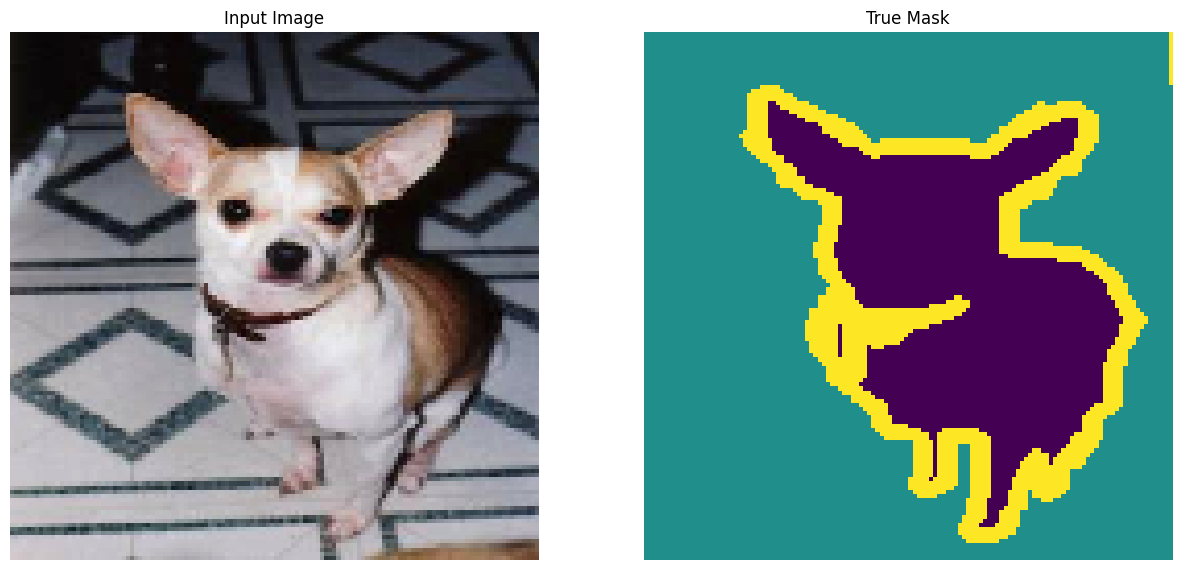

In [10]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [65]:
#Define architecture here

# Positional Embedding Function
def get_positional_embeddings(seq_len, d_model):
    pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return tf.expand_dims(pos_encoding, axis=0)  # shape: (1, seq_len, d_model)

# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='gelu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ViT-U-Net Model
def small_vit_unet_segmentation_model(
    input_shape=(128, 128, 3),
    patch_size=16,
    num_classes=3,
    projection_dim=64,
    transformer_layers=2,
    num_heads=2,
    ff_dim=128,
):
    inputs = layers.Input(shape=input_shape)
    patch_h = patch_w = patch_size
    patch_grid_size = input_shape[0] // patch_size
    num_patches = patch_grid_size ** 2

    # Patch extraction
    def extract_patches_fn(x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_h, patch_w, 1],
            strides=[1, patch_h, patch_w, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return tf.reshape(patches, [tf.shape(x)[0], -1, patch_h * patch_w * input_shape[2]])

    patches = layers.Lambda(extract_patches_fn)(inputs)
    x = layers.Dense(projection_dim)(patches)

    # Add positional encoding
    pos_encoding = get_positional_embeddings(num_patches, projection_dim)
    x = x + pos_encoding[:, :num_patches, :]

    # Transformer blocks
    for _ in range(transformer_layers):
        x = TransformerBlock(projection_dim, num_heads, ff_dim)(x)

    # Bottleneck
    x = layers.Reshape((patch_grid_size, patch_grid_size, projection_dim))(x)

    # Decoder: upscale back to 128x128
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)  # 8 → 16
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)   # 16 → 32
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)   # 32 → 64
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)   # 64 → 128 ✅


    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="SmallViT-U-Net")

In [66]:
# Define the model
unet_model = small_vit_unet_segmentation_model(input_shape=(128, 128, 3))

In [67]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

In [68]:
#Define training parameters and start training

NUM_EPOCHS = 20.  #Train for more epochs for possibly better results
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              verbose=1,
                              validation_data=test_batches)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - accuracy: 0.5597 - loss: 0.9702 - val_accuracy: 0.6532 - val_loss: 0.7812
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.6956 - loss: 0.7458 - val_accuracy: 0.7293 - val_loss: 0.6815
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.7332 - loss: 0.6747 - val_accuracy: 0.7373 - val_loss: 0.6618
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.7426 - loss: 0.6554 - val_accuracy: 0.7484 - val_loss: 0.6382
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.7471 - loss: 0.6374 - val_accuracy: 0.7498 - val_loss: 0.6258
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.7586 - loss: 0.6105 - val_accuracy: 0.7599 - val_loss: 0.5987
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.7625 - loss: 0.5976 - val_accuracy: 0.7503 - val_loss: 0.6258
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.7656 - loss: 0.5899 - val_accu

In [69]:
import matplotlib.pyplot as plt

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display_images(image[0], mask[0], create_mask(pred_mask))
    else:
        pred = model.predict(sample_image[tf.newaxis, ...])
        display_images(sample_image, sample_mask, create_mask(pred))

def display_images(image, mask, pred_mask):
    plt.figure(figsize=(15, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    images = [image, mask, pred_mask]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        if images[i].shape[-1] == 1:
            plt.imshow(tf.squeeze(images[i]), cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis('off')

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


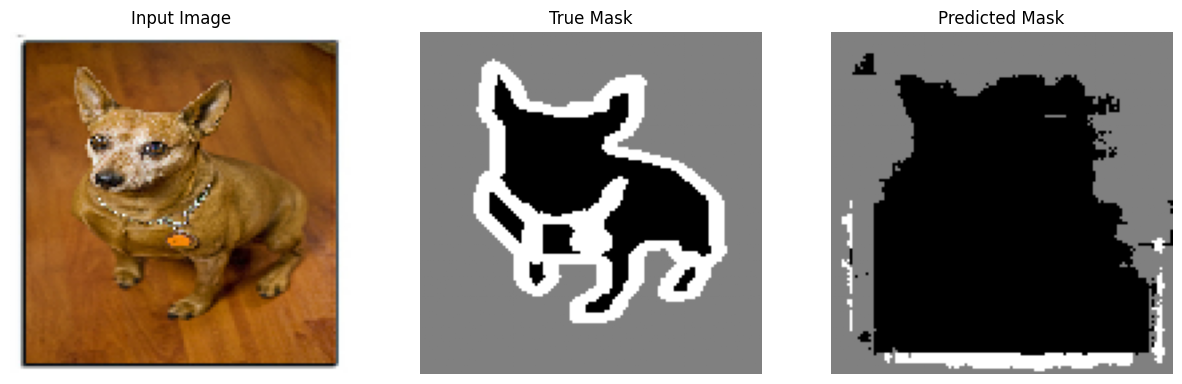

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


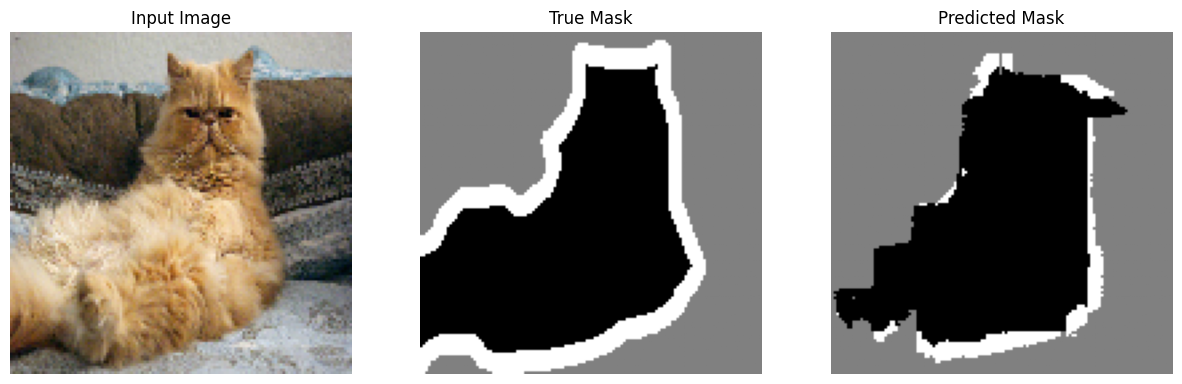

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


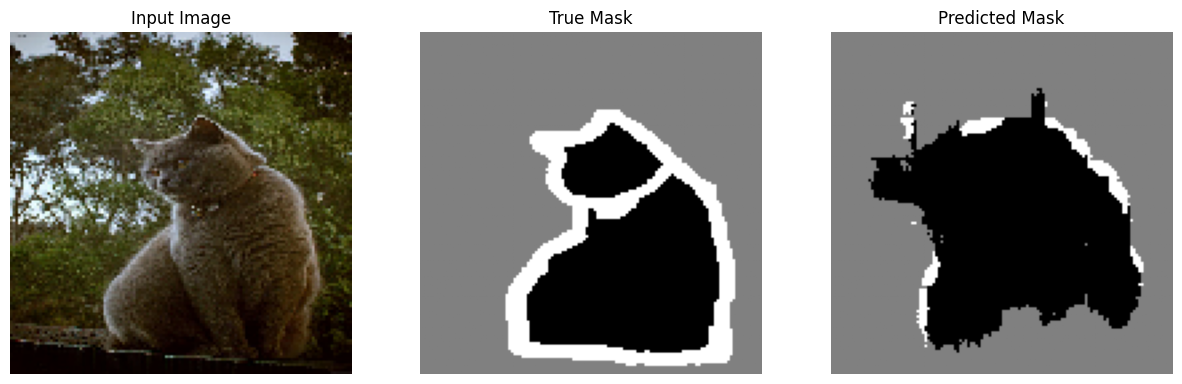

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 


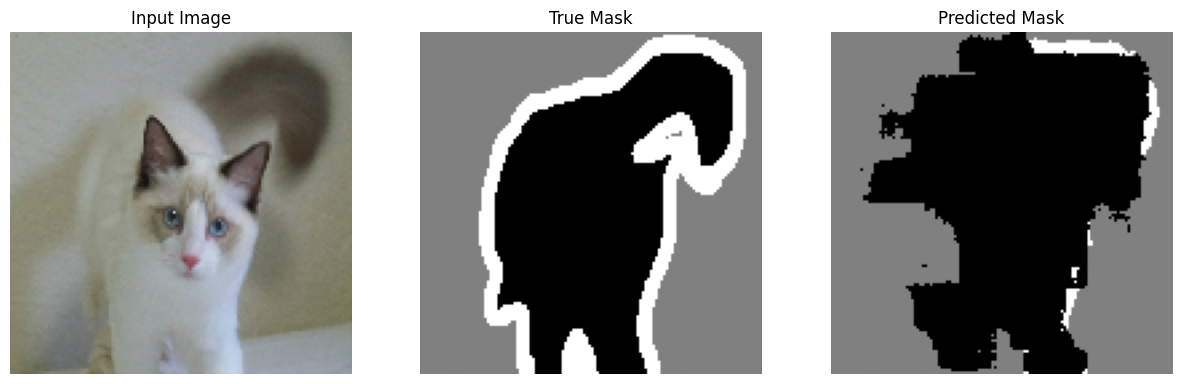

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


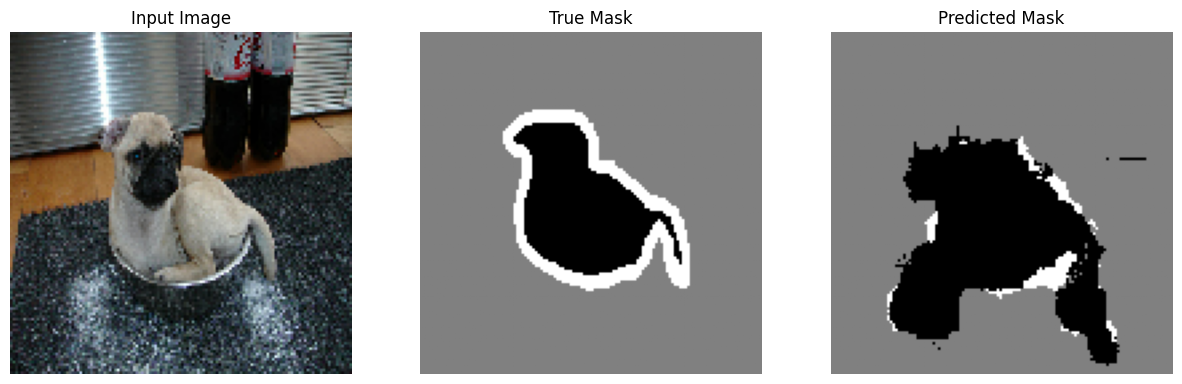

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


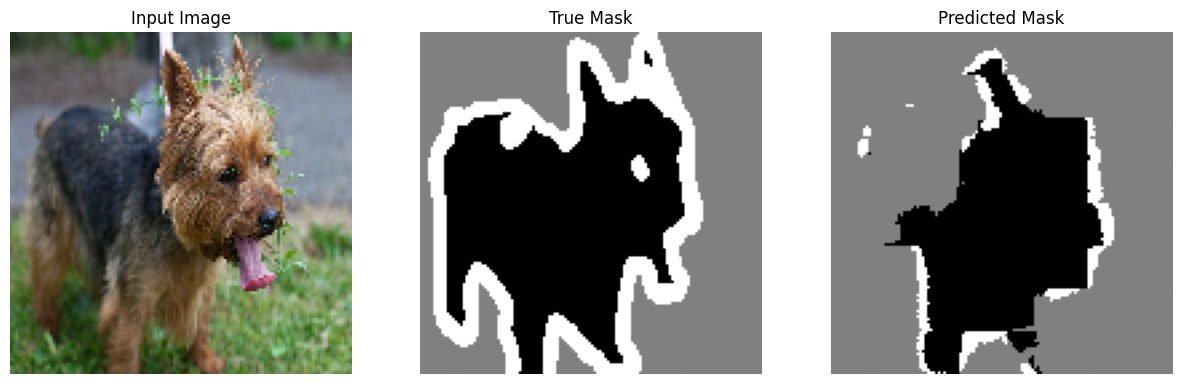

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


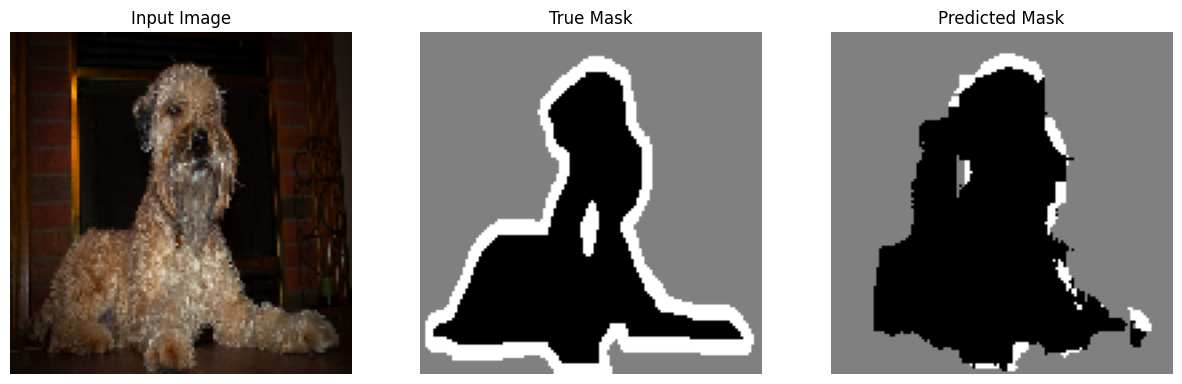

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


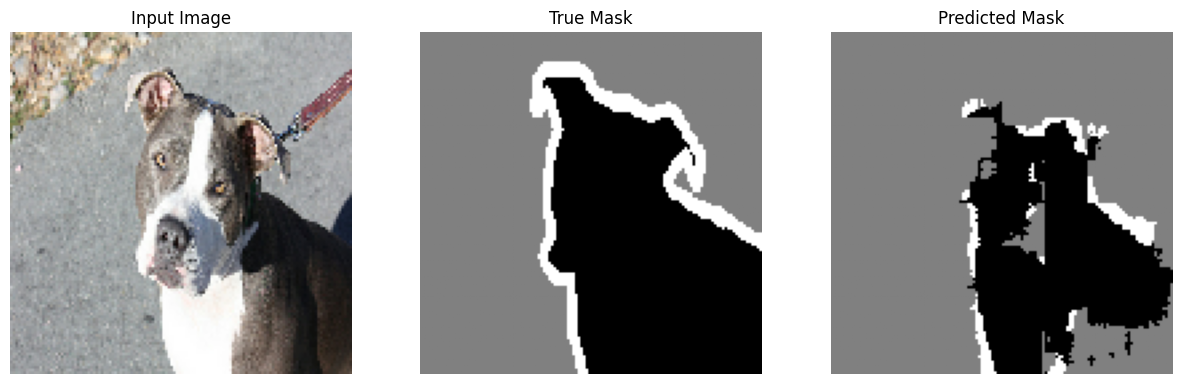

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


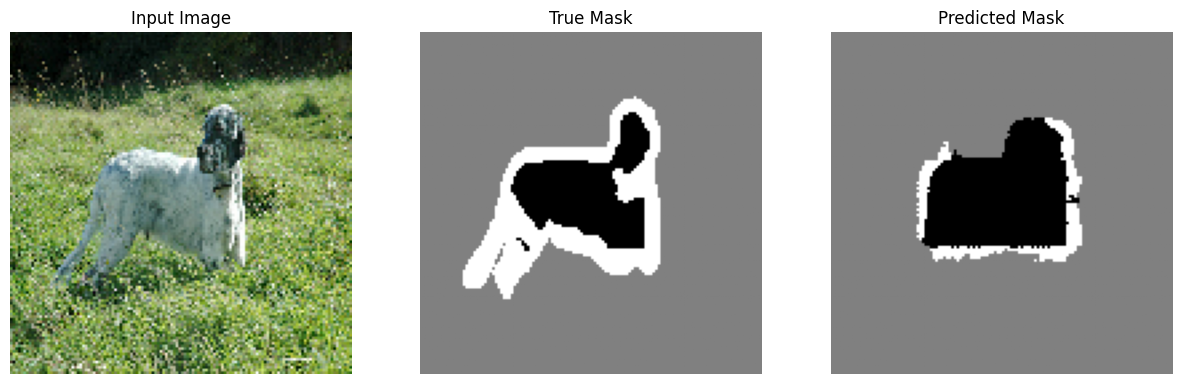

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


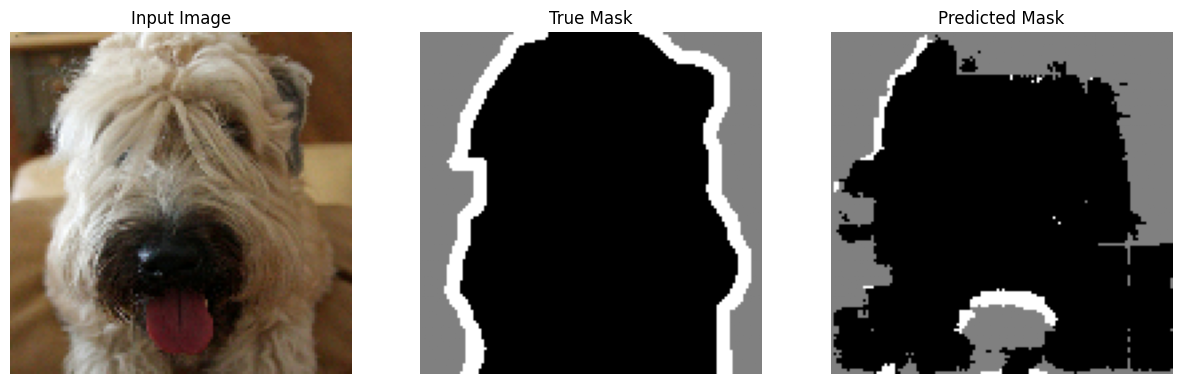

In [70]:
show_predictions(dataset=test_batches, num=10)